## Import libraries


In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [42]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import plot_model
from transformers import TFBertModel, BertConfig, BertTokenizerFast
from tensorflow.python.keras import backend as K
import matplotlib.pyplot as plt
import keras

In [3]:
import torch.nn.functional as Fun
import torch

## Import Data

In [4]:
#Read data
df=pd.read_csv('/flush5/sou090/01 - Project/c-24/data_c_24.csv')
df.head()

,Unnamed: 0,text,value
0,0,"(1) a Federal, State, or local law enforcement...",4.0
1,1,"(1) a Federal, State, or local law enforcement...",4.0
2,2,(1) announcing the change on the home page of ...,2.0
3,3,(1) comply with the law or legal processes;,4.0
4,4,(1) comply with the law or with legal process;,4.0


In [5]:
type(df['value'][2])

numpy.float64

### 1. Encode Labels

In [6]:
from sklearn.preprocessing import OneHotEncoder 

In [7]:
one=OneHotEncoder(sparse=False)
encoded=one.fit_transform(df[['value']])
len(encoded)

29740

### 2. Creat new data with the encoded value

In [8]:
head = {'text' : [], 'value' : []}
df_model = pd.DataFrame(head,dtype=object)

In [9]:
for k in tqdm(range (len(df))):
    df_model.loc[k]=[df['text'][k],encoded[k]]
df_model.head(10)

100%|██████████| 29740/29740 [01:27<00:00, 341.65it/s]


,text,value
0,"(1) a Federal, State, or local law enforcement...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"
1,"(1) a Federal, State, or local law enforcement...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"
2,(1) announcing the change on the home page of ...,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]"
3,(1) comply with the law or legal processes;,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"
4,(1) comply with the law or with legal process;,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"
5,(1) following the \,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
6,(1) identify the terms of any special offers y...,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"
7,(1) identify the terms of any special offers y...,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0]"
8,(1) information we receive from you,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0]"
9,"(1) personal information,","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0]"


### 2. Create the new data

In [10]:
#Split data
train_df, test_df = train_test_split(df_model,test_size=0.1)
print(len(train_df),len(test_df))

26766 2974


### Check the len max of the word

In [11]:
ex_len = []
for i in train_df['text']:
  ex_len.append(len(i.split()))
print('max length of text: ', max(ex_len), 'words')

max length of text:  254 words


## Tokenize

In [12]:
bert_model = 'bert-base-uncased'
tokenizer = BertTokenizerFast.from_pretrained(bert_model)

In [13]:
# Encoder the function to tokenize the data
def encoder(df, tokenizer, label = 'text', maxLen = 254):
    input_id = []
    token_type = []
    attention_mask = []
    for i in df[label].values:
        token = tokenizer(i, max_length = maxLen, truncation = True, padding = 'max_length', add_special_tokens = True)
        input_id.append(token['input_ids'])
        token_type.append(token['token_type_ids'])
        attention_mask.append(token['attention_mask'])
    return np.array(input_id), np.array(token_type), np.array(attention_mask)

In [14]:
#Call the function to tokenize data
train_d = encoder(train_df, tokenizer)
test_d = encoder(test_df, tokenizer)

# Config of Bert

In [15]:
model_config = BertConfig.from_pretrained(bert_model)

In [16]:
model_config.output_hidden_states = True
model_config

BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_hidden_states": true,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.22.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

## Parameters

In [17]:
bert = TFBertModel.from_pretrained(bert_model, config = model_config)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


### Tunable parameters

In [18]:
# tunable parameters
max_len = 254
#fix learning_rate
learning_rate = 1e-4
epochs = 3

In [19]:
#callbacks
ckpt_dir = 'ckpt{epoch:02d}.h5'
ckpt = ModelCheckpoint(
    filepath = ckpt_dir,
    save_freq = 'epoch',
    save_weights_only=True)
callbacks = [ckpt]

In [20]:
#optimizer = Adam(learning_rate = learning_rate)
optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate)

In [21]:
#Loss
loss = 'categorical_crossentropy'

In [22]:
#Metrics
metrics=tf.keras.metrics.CategoricalAccuracy(name="accuracy", dtype=None)

### Bert

In [23]:
input_ids_i = Input(shape = (max_len, ), dtype = tf.int32, name = 'input_ids')
token_type_ids_i = Input(shape = (max_len, ), dtype = tf.int32, name = 'token_type_ids')
attention_mask_i = Input(shape = (max_len, ), dtype = tf.int32, name = 'attention_mask')
inputs = [input_ids_i, token_type_ids_i, attention_mask_i]

bert_output = bert(input_ids_i, token_type_ids = token_type_ids_i, attention_mask = attention_mask_i)[0]

## Add layers

In [24]:
bert_output = bert(input_ids_i, token_type_ids = token_type_ids_i, attention_mask = attention_mask_i)[0]
output = bert_output[:, 0, :]

output = Dropout(0.2)(output)

output =Dense(50,activation='relu')(output)
output=Dense(50,activation='relu')(output)
output = Dense(6, activation = 'softmax')(output) #Adding a softmax layer for softmax regression with categorical 
#cross entropy

model = Model(inputs = inputs, outputs = output)

model.compile(loss = loss, optimizer = optimizer, metrics = metrics)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 254)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 254)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 254)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]',     

In [25]:
model.layers[3].trainable = False # Trying to make the bert layers non-trainable
model.compile(loss = loss, optimizer = optimizer, metrics = metrics)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 254)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 254)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 254)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]',     

In [26]:
bert_output

<KerasTensor: shape=(None, 254, 768) dtype=float32 (created by layer 'tf_bert_model')>

In [27]:
# Datas
train_l = train_df['value'].values

val_prob = 0.1
split = int(len(train_l)*(1 - val_prob))

train_x = tuple(np.array(train_d)[:, :split, :])
train_y =np.array(train_l)[:split]

val_x = tuple(np.array(train_d)[:, split:, :])
val_y =np.array(train_l)[split:]

In [28]:
train_yl = []
val_yl = []
for i in range(0,train_y.shape[0]):
    train_yl.append(list(train_y[i]))
for i in range(0,val_y.shape[0]):
    val_yl.append(list(val_y[i]))

In [29]:
train_yll = np.asarray(train_yl).astype(np.float32)
val_yl1 = np.asarray(val_yl).astype(np.float32)

## Train the model 

In [30]:
history=model.fit(train_x, train_yll, validation_data = (val_x, val_yl1), epochs = 15)

Epoch 1/15
753/753 [==============================] - 313s 391ms/step - loss: 1.2950 - accuracy: 0.4670 - val_loss: 1.1080 - val_accuracy: 0.5532
Epoch 2/15
753/753 [==============================] - 285s 378ms/step - loss: 1.1103 - accuracy: 0.5426 - val_loss: 1.0286 - val_accuracy: 0.5827
Epoch 3/15
753/753 [==============================] - 284s 378ms/step - loss: 1.0619 - accuracy: 0.5608 - val_loss: 0.9842 - val_accuracy: 0.6003
Epoch 4/15
753/753 [==============================] - 285s 379ms/step - loss: 1.0299 - accuracy: 0.5729 - val_loss: 0.9590 - val_accuracy: 0.6093
Epoch 5/15
753/753 [==============================] - 284s 378ms/step - loss: 1.0070 - accuracy: 0.5840 - val_loss: 0.9352 - val_accuracy: 0.6257
Epoch 6/15
753/753 [==============================] - 287s 381ms/step - loss: 0.9948 - accuracy: 0.5906 - val_loss: 0.9194 - val_accuracy: 0.6246
Epoch 7/15
753/753 [==============================] - 287s 381ms/step - loss: 0.9862 - accuracy: 0.5932 - val_loss: 0.9025 -

In [31]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


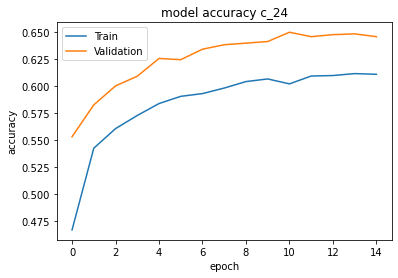

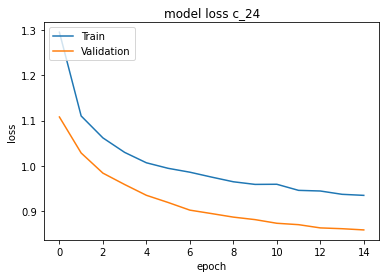

In [41]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy c_24')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss c_24')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


## Test the model 

In [33]:
test_model=tuple(np.array(test_d))
test_model_val=np.array(test_df['value'].values)

In [34]:
test_yl = []

for i in range(0,len(test_model)):
    test_yl.append(list(test_model_val[i]))

In [36]:
def maximum (l):
    u=0
    max=0
    for k in range (len(l)):
        if l[k]>max:
            max=l[k]
            u=k
    return(u)

In [35]:
a=model.predict(test_model)

In [37]:
i=0
j=0

for k in range (len(a)):
    if maximum(a[k])==maximum(test_model_val[k]):
        i=i+1
    else: 
        j=j+1
print('the model has {} good answers'.format(i))
print('the model has {} bad answers'.format(j))
print('The accuracy is {}'.format(i/(i+j)))

the model has 1881 good answers
the model has 1093 bad answers
The accuracy is 0.632481506388702


In [39]:
model.save('model_project22.h5')

In [43]:
model_porject22 = loaded_model = tf.keras.models.load_model('model_project22.h5', custom_objects={"TFBertModel": transformers.TFBertModel})

NameError: name 'transformers' is not defined

###### 